В этом файле происходит формирование train и test признаков для модели. 
1. Добавление в общую таблицу признака количества транзакций.

2. Добавление в общую таблицу признаков, отличающих одинаковые магазины по местоположению и типу

3. Добавление в общую таблицу признаков цен на нефть и лагов дат

4. Добавление в таблицу дней выплаты зарплат и дней после этого

5. Добавление информации о праздниках

6. Добавление информации о землятресении

In [79]:
import pandas as pd
from tqdm import tqdm
pd.options.display.max_columns = 500
import numpy as np

In [80]:
holidays_events=pd.read_csv('holidays_events.csv',sep=',')
oil=pd.read_csv('oil.csv',sep=',')
sample_submission=pd.read_csv('sample_submission.csv',sep=',')
stores=pd.read_csv('stores.csv',sep=',')
test=pd.read_csv('test.csv',sep=',')
train=pd.read_csv('train.csv',sep=',')
transaction=pd.read_csv('transactions.csv',sep=',')

In [81]:
test.head(3)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2


In [82]:
oil.head(3)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


# Добавить в общую таблицу признак количества транзакций.

In [83]:
train.isna().sum().sum()

0

Проверим, как луше заполнить пропуски данных. Если ненормальное распределение, то лучше медианой. Если нормальное, то средним

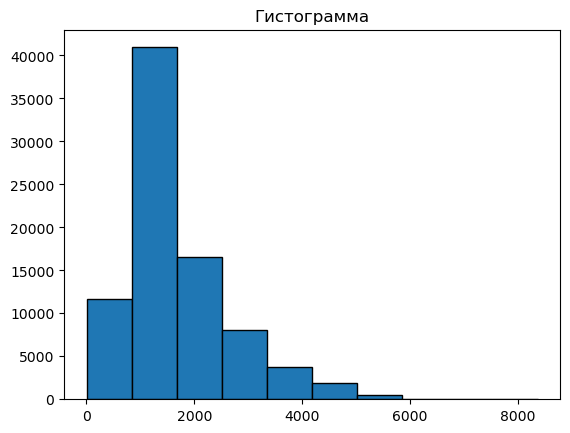

In [84]:
import matplotlib.pyplot as plt

# Пример данных
data = transaction.transactions

# Построение гистограммы
plt.hist(data, bins=10, edgecolor='black')
plt.title('Гистограмма')
plt.show()

In [85]:
from scipy.stats import shapiro

stat, p = shapiro(data)
print(f"Статистика теста: {stat}, p-значение: {p}")

if p > 0.05:
    print("Данные нормально распределены (не отвергаем H0).")
else:
    print("Данные не нормально распределены (отвергаем H0).")

Статистика теста: 0.8657199740409851, p-значение: 0.0
Данные не нормально распределены (отвергаем H0).


D:\Anaconda\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Не добавлен в общую таблицу признак количества транзакций, т.к. для теста нет данных


# Добавить в общую таблицу признаки, отличающие одинаковые магазины по местоположению и типу

In [86]:
stores.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


In [87]:
train = pd.merge(train, stores, on='store_nbr', how='left')


In [88]:
train.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13


In [89]:
df=train


In [90]:
### Преобразуем категориальные колонки

for col in ["city","state","type", "cluster"]:
    if col != 'timestamp': 
        if df[col].nunique() < 5:
            one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

        else:
            mean_target = df.groupby(col)['sales'].mean()
            df[col] = df[col].map(mean_target)

In [91]:
### Преобразуем категориальные колонки
for col in ["family"]:
    mean_target = df.groupby(col)['sales'].mean()
    df["family_1"] = df[col].map(mean_target)

In [92]:
train = df
train.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,family_1
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,556.57709,554.110358,350.979407,324.364108,6.101236
1,1,2013-01-01,1,BABY CARE,0.0,0,556.57709,554.110358,350.979407,324.364108,0.110528
2,2,2013-01-01,1,BEAUTY,0.0,0,556.57709,554.110358,350.979407,324.364108,3.715723


In [93]:
a = train.copy()

In [94]:
indexes = a.store_nbr.drop_duplicates()

In [95]:
indexes.index

Index([   0,   33,   66,   99,  132,  165,  198,  231,  264,  297,  330,  363,
        396,  429,  462,  495,  528,  561,  594,  627,  660,  693,  726,  759,
        792,  825,  858,  891,  924,  957,  990, 1023, 1056, 1089, 1122, 1155,
       1188, 1221, 1254, 1287, 1320, 1353, 1386, 1419, 1452, 1485, 1518, 1551,
       1584, 1617, 1650, 1683, 1716, 1749],
      dtype='int64')

In [96]:
stores_for_test = train.loc[indexes.index]

In [97]:
stores_for_test.head(1)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,family_1
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,556.57709,554.110358,350.979407,324.364108,6.101236


In [98]:
stores_for_test = stores_for_test.drop([
    'id',
    'date',
    'family',
    'sales',
    'onpromotion',
    'family_1',
], axis=1)

In [99]:
stores_for_test.head(2)

,store_nbr,city,state,type,cluster
0,1,556.57709,554.110358,350.979407,324.364108
33,10,556.57709,554.110358,197.263301,199.010111


In [100]:
test = pd.merge(test, stores_for_test, on='store_nbr', how='left')


In [101]:
indexes_family = train.family.drop_duplicates()

In [102]:
family_for_test = train.loc[indexes_family.index]

In [103]:
family_for_test = family_for_test.drop([
    'id',
    'date',
    'sales',
    'onpromotion',
    'store_nbr',
    'city',
    'state',
    'type',
    'cluster',
], axis=1)


In [104]:
family_for_test.head(1)

,family,family_1
0,AUTOMOTIVE,6.101236


In [105]:
test = pd.merge(test, family_for_test, on='family', how='left')


In [106]:
test.head(3)

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,family_1
0,3000888,2017-08-16,1,AUTOMOTIVE,0,556.57709,554.110358,350.979407,324.364108,6.101236
1,3000889,2017-08-16,1,BABY CARE,0,556.57709,554.110358,350.979407,324.364108,0.110528
2,3000890,2017-08-16,1,BEAUTY,2,556.57709,554.110358,350.979407,324.364108,3.715723


In [107]:
test = test.drop([
    'family'
], axis=1)


In [108]:
test = test.rename(columns={"family_1": "family"})

In [109]:
test.head(3)

,id,date,store_nbr,onpromotion,city,state,type,cluster,family
0,3000888,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,6.101236
1,3000889,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,0.110528
2,3000890,2017-08-16,1,2,556.57709,554.110358,350.979407,324.364108,3.715723


In [110]:
train = train.drop([
    'family'
], axis=1)


In [111]:
train = train.rename(columns={"family_1": "family"})

In [112]:
train.head(3)

,id,date,store_nbr,sales,onpromotion,city,state,type,cluster,family
0,0,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,6.101236
1,1,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,0.110528
2,2,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,3.715723


# Добавить в общую таблицу признак цен на нефть и доп. дат

1. Добавить лаги 6 штук к ценам на нефть
2. Столбец цен на нефть взять на кадый день
3. Заполнить пропуски последними значениями

4. Добавить ко всем датам номер недели, викенд 1/0
5. добавить лаги 6 штук к датам

6. Смержить с train и сделать mean encoding
7. Из train извлечь и смержить с test

In [114]:

oil['date'] = pd.to_datetime(oil['date'])

In [115]:
all_dates = pd.DataFrame({'date':pd.date_range(start='2013-01-01',periods=1704)})

In [116]:
all_dates.isna().sum().sum()

0

In [117]:
oil = oil.fillna(method='ffill')

In [118]:
oil.at[0, 'dcoilwtico'] = oil.at[1, 'dcoilwtico']

In [120]:
all_dates = pd.merge(all_dates, oil, on='date', how='left')

In [121]:
all_dates.head(2)

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14


In [122]:
all_dates = all_dates.fillna(method='ffill')

In [123]:
all_dates['dcoilwtico_lag_1'] = all_dates['dcoilwtico'].shift(1)

In [124]:
all_dates['dcoilwtico_lag_2'] = all_dates['dcoilwtico'].shift(2)
all_dates['dcoilwtico_lag_3'] = all_dates['dcoilwtico'].shift(3)
all_dates['dcoilwtico_lag_4'] = all_dates['dcoilwtico'].shift(4)
all_dates['dcoilwtico_lag_5'] = all_dates['dcoilwtico'].shift(5)
all_dates['dcoilwtico_lag_6'] = all_dates['dcoilwtico'].shift(6)

In [125]:
all_dates = all_dates.fillna(93.14)

In [126]:
only_oil_prices_with_lags = all_dates.copy()

In [127]:
all_dates.head(3)

,date,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6
0,2013-01-01,93.14,93.14,93.14,93.14,93.14,93.14,93.14
1,2013-01-02,93.14,93.14,93.14,93.14,93.14,93.14,93.14
2,2013-01-03,92.97,93.14,93.14,93.14,93.14,93.14,93.14


In [128]:
 all_dates['day_of_week'] =  all_dates['date'].dt.dayofweek

In [129]:
all_dates['weekend'] = 0
for i in range(0, 1704, 1):
    if all_dates['day_of_week'][i] == 5 or all_dates['day_of_week'][i] == 6:
        all_dates['weekend'][i] = 1        


C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3037911228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['weekend'][i] = 1
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3037911228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['weekend'][i] = 1
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3037911228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['weekend'][i] = 1
C:\Users\Фёдор\AppD

In [130]:
all_dates.head(3)

,date,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6,day_of_week,weekend
0,2013-01-01,93.14,93.14,93.14,93.14,93.14,93.14,93.14,1,0
1,2013-01-02,93.14,93.14,93.14,93.14,93.14,93.14,93.14,2,0
2,2013-01-03,92.97,93.14,93.14,93.14,93.14,93.14,93.14,3,0


In [131]:
all_dates['day_of_week_1'] = all_dates['day_of_week'].shift(1)
all_dates['day_of_week_2'] = all_dates['day_of_week'].shift(2)
all_dates['day_of_week_3'] = all_dates['day_of_week'].shift(3)
all_dates['day_of_week_4'] = all_dates['day_of_week'].shift(4)
all_dates['day_of_week_5'] = all_dates['day_of_week'].shift(5)
all_dates['day_of_week_6'] = all_dates['day_of_week'].shift(6)

Добавили лаги, но первые значения в сттроках отсутствуют, так как данных за 6 дней до 2023-01-01 нет. Поэтому эти дни зададим следующими циклами.

In [132]:
k = 0
start = 2
for i in range(0, 6, 1):
    all_dates['day_of_week_6'][k] = start
    start = start + 1
    k = k + 1
all_dates['day_of_week_6'][5] = 0

C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\1745478151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_6'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\1745478151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_6'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\1745478151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_6'][

In [133]:
k = 0
start = 3
for i in range(0, 5, 1):
    all_dates['day_of_week_5'][k] = start
    start = start + 1
    k = k + 1
all_dates['day_of_week_5'][4] = 0

C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3161398014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_5'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3161398014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_5'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3161398014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_5'][

In [134]:
k = 0
start = 4
for i in range(0, 4, 1):
    all_dates['day_of_week_4'][k] = start
    start = start + 1
    k = k + 1
all_dates['day_of_week_4'][3] = 0

C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3481714965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_4'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3481714965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_4'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3481714965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_4'][

In [135]:
k = 0
start = 5
for i in range(0, 3, 1):
    all_dates['day_of_week_3'][k] = start
    start = start + 1
    k = k + 1
all_dates['day_of_week_3'][2] = 0

C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3658670497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_3'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3658670497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_3'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3658670497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_3'][

In [136]:
k = 0
start = 6
for i in range(0, 2, 1):
    all_dates['day_of_week_2'][k] = start
    start = start + 1
    k = k + 1
all_dates['day_of_week_2'][1] = 0

C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3266830386.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_2'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3266830386.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_2'][k] = start
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3266830386.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_2'][

In [137]:
all_dates['day_of_week_1'][0] = 0

C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3356877905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_dates['day_of_week_1'][0] = 0


In [138]:
train['date'] = pd.to_datetime(train['date'])
train = pd.merge(train, all_dates, on='date', how='left')
### Преобразуем категориальные колонки

for col in ["day_of_week"
           ]:
    mean_target = train.groupby(col)['sales'].mean()
    train[col] = train[col].map(mean_target)


Добавили даты и лаги дат. Рассчитали для столбца "day_of_week" средние значения продаж. Далее нужно остальным столбцам лагов присвоить значения, рассчитанные по MTE методу.

In [139]:
# Функция для преобразования значений
def transform_value(val):
    if val == 0:
        return 346.544732
    elif val == 1:
        return 319.823843
    elif val == 2:
        return 332.909401
    elif val == 3:
        return 283.540517
    elif val == 4:
        return 325.238138
    elif val == 5:
        return 433.336472
    elif val == 6:
        return 463.085366
    return val  # если значение не от 0 до 6, оставить его как есть

# Применяем трансформацию ко всем нужным столбцам
for col in tqdm(['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']):
    train[col] = train[col].apply(transform_value)

100%|████████████████████████████████████████| 6/6 [00:05<00:00,  1.05it/s]


In [140]:
train.head(3)

,id,date,store_nbr,sales,onpromotion,city,state,type,cluster,family,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,0,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,6.101236,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401
1,1,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,0.110528,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401
2,2,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,3.715723,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401


Чтобы для test добавить те же колонки что и в train, временно добавим и потом удалим столбец number_week_day в train 

In [141]:
train['number_week_day'] =   train['date'].dt.dayofweek


In [142]:
test['date'] = pd.to_datetime(test['date'])
test['number_week_day'] =   test['date'].dt.dayofweek


In [143]:
train_unique_dates = train.drop_duplicates(subset=['number_week_day'])

In [144]:
train_unique_dates =  train_unique_dates.iloc[:,-9:]

In [145]:
train_unique_dates.head(3)

,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,number_week_day
0,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,1
1782,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,2
3564,283.540517,0,332.909401,319.823843,346.544732,463.085366,433.336472,325.238138,3


In [146]:
test = pd.merge(test, train_unique_dates, on='number_week_day', how='left')

In [147]:
train = train.drop([
            'number_week_day'], axis=1)

test = test.drop([
            'number_week_day'], axis=1)

In [148]:
test = pd.merge(test, only_oil_prices_with_lags, on='date', how='left')

In [149]:
test.head(3)

,id,date,store_nbr,onpromotion,city,state,type,cluster,family,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6
0,3000888,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,6.101236,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54
1,3000889,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,0.110528,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54
2,3000890,2017-08-16,1,2,556.57709,554.110358,350.979407,324.364108,3.715723,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54


Left join прост добавляет ко всей левой таблице то, что есть из правой

# Добавить в таблицу заработные платы и дни после них

In [150]:
pd.Period('10-DEC-20',freq='M').end_time.date()

datetime.date(2020, 12, 31)

In [151]:
train.date[1]

Timestamp('2013-01-01 00:00:00')

In [152]:
pd.Period(train.date[1],freq='M').end_time.date()

datetime.date(2013, 1, 31)

In [153]:
pd.Timestamp("2014-01-02") + pd.offsets.MonthEnd(n=1)

Timestamp('2014-01-31 00:00:00')

In [154]:
oil.head(3)

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97


In [155]:
salary = pd.DataFrame({'date':pd.date_range(start='2013-01-01',periods=1704)})
salary.head(3)

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03


In [156]:
salary.head(3)

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03


In [157]:
salary.dtypes

date    datetime64[ns]
dtype: object

In [158]:
pd.Period(salary.date[1],freq='M').end_time.date()

datetime.date(2013, 1, 31)

In [159]:
salary['day_end_month'] = 0
salary['day_end_month'] = pd.to_datetime(salary['day_end_month'])
for i in range(0, 1704, 1):
    salary['day_end_month'][i] = pd.Period(salary.date[i],freq='M').end_time.date()

In [160]:
salary['day_15_of_month'] = salary.date.dt.day

In [161]:
salary.head(3)

,date,day_end_month,day_15_of_month
0,2013-01-01,2013-01-31,1
1,2013-01-02,2013-01-31,2
2,2013-01-03,2013-01-31,3


In [162]:
salary['salary_day_of_month'] = 0
salary['day_end_month'] = pd.to_datetime(salary['day_end_month'])
for i in range(0, 1704, 1):
    if salary['day_end_month'][i] == salary['date'][i] or salary['day_15_of_month'][i] == 15:
        salary['salary_day_of_month'][i] = 1

C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3635454540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary['salary_day_of_month'][i] = 1
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3635454540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary['salary_day_of_month'][i] = 1
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3635454540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary['salary_day_of_month']

Считаю, дни после зарплат тоже обозначить важно весовыми коэффициентами по убывающей. То есть чем дальше от дня зарплаты, тем меньше денег у людей и меньше продаж у магазинов. Чтобы это учесть ввел коэффициенты от 0.8 до 0.1.

In [163]:
for i in range(0, 1704, 1):
    if salary['salary_day_of_month'][i] == 1:
        salary['salary_day_of_month'][i+1] = 0.8
        salary['salary_day_of_month'][i+2] = 0.6
        salary['salary_day_of_month'][i+3] = 0.4
        salary['salary_day_of_month'][i+4] = 0.2   
        salary['salary_day_of_month'][i+5] = 0.1
        salary['salary_day_of_month'][i+6] = 0.1       

C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3630954742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary['salary_day_of_month'][i+1] = 0.8
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3630954742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary['salary_day_of_month'][i+2] = 0.6
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3630954742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salary['salary_day_of

In [164]:
salary.head(3)

,date,day_end_month,day_15_of_month,salary_day_of_month
0,2013-01-01,2013-01-31,1,0.0
1,2013-01-02,2013-01-31,2,0.0
2,2013-01-03,2013-01-31,3,0.0


In [165]:
salary = salary.drop([
            'day_15_of_month',
            'day_end_month'], axis=1)
salary.head(3)

,date,salary_day_of_month
0,2013-01-01,0.0
1,2013-01-02,0.0
2,2013-01-03,0.0


In [166]:
train = pd.merge(train, salary, on=['date'], how='left')
train.head(3)

,id,date,store_nbr,sales,onpromotion,city,state,type,cluster,family,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,salary_day_of_month
0,0,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,6.101236,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0
1,1,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,0.110528,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0
2,2,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,3.715723,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0


In [167]:
test['date'] = pd.to_datetime(test['date'])

In [168]:
test = pd.merge(test, salary, on=['date'], how='left')
test.head(3)

,id,date,store_nbr,onpromotion,city,state,type,cluster,family,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6,salary_day_of_month
0,3000888,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,6.101236,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54,0.8
1,3000889,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,0.110528,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54,0.8
2,3000890,2017-08-16,1,2,556.57709,554.110358,350.979407,324.364108,3.715723,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54,0.8


Добавлена в  таблицу ЗП и дня рядом

# Добавить инфу о праздниках

По праздникам сложная структура данных. Колонка type может принимать значения: Bridge, Event, Holiday, Transfer, Work_day. Bridge - значит дополнительный день отдыха между праздником и выходным. Event и Holiday - это просто выходные. Work_day - рабочий день. Transfer - это день, когда празднуют. Столбец transferred означает что этот праздник перенесен с этого дня и в этот день рабочий день.

Решено сделать OHE метод преобразования категориальных признаков, потому что в test этих данных нет. Так проще потом сформировать train и test

In [169]:
date_holidays_train_test = pd.DataFrame({'date':pd.date_range(start='2013-01-01',periods=1704)})

In [170]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

In [171]:
date_holidays_train_test = pd.merge(date_holidays_train_test, holidays_events, on=['date'], how='left')


In [172]:

 holidays_events[holidays_events.date.duplicated(keep=False)].head(3)

,date,type,locale,locale_name,description,transferred
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [173]:
### Преобразуем категориальные колонки

for col in ["type","locale", "locale_name"]:
    one_hot = pd.get_dummies(date_holidays_train_test[col], prefix=col, drop_first=True)
    date_holidays_train_test = pd.concat((date_holidays_train_test.drop(col, axis=1), one_hot), axis=1)


In [174]:
date_holidays_train_test = date_holidays_train_test.drop([
            'description'], axis=1)
date_holidays_train_test.head(3)

,date,transferred,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,locale_name_Cayambe,locale_name_Cotopaxi,locale_name_Cuenca,locale_name_Ecuador,locale_name_El Carmen,locale_name_Esmeraldas,locale_name_Guaranda,locale_name_Guayaquil,locale_name_Ibarra,locale_name_Imbabura,locale_name_Latacunga,locale_name_Libertad,locale_name_Loja,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas
0,2013-01-01,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [175]:
date_holidays_train_test[
    'transferred'
] = date_holidays_train_test[
    'transferred'
].fillna(0)

In [176]:
for i in date_holidays_train_test.columns:
    if i != 'date':
        date_holidays_train_test[i] = date_holidays_train_test[i].astype(int)

Добавлена инфа о праздниках

In [177]:
train = pd.merge(train, date_holidays_train_test, on=['date'], how='left')
train.head(3)

,id,date,store_nbr,sales,onpromotion,city,state,type,cluster,family,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,salary_day_of_month,transferred,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,locale_name_Cayambe,locale_name_Cotopaxi,locale_name_Cuenca,locale_name_Ecuador,locale_name_El Carmen,locale_name_Esmeraldas,locale_name_Guaranda,locale_name_Guayaquil,locale_name_Ibarra,locale_name_Imbabura,locale_name_Latacunga,locale_name_Libertad,locale_name_Loja,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas
0,0,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,6.101236,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,0.110528,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,3.715723,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [178]:
test = pd.merge(test, date_holidays_train_test, on=['date'], how='left')
test.head(3)

,id,date,store_nbr,onpromotion,city,state,type,cluster,family,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6,salary_day_of_month,transferred,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,locale_name_Cayambe,locale_name_Cotopaxi,locale_name_Cuenca,locale_name_Ecuador,locale_name_El Carmen,locale_name_Esmeraldas,locale_name_Guaranda,locale_name_Guayaquil,locale_name_Ibarra,locale_name_Imbabura,locale_name_Latacunga,locale_name_Libertad,locale_name_Loja,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas
0,3000888,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,6.101236,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3000889,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,0.110528,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3000890,2017-08-16,1,2,556.57709,554.110358,350.979407,324.364108,3.715723,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Добвить инфу о землятресении

В данных нужно учесть сильный выброс из-за землетрясения. Продажи товаров первой необходимости взлетели. Цена на нефть изменилась резко. Дни после землятресения беру с коэффициентами меньше 1 от 0,9 до 0,1

In [189]:
earthquake = pd.DataFrame({'date':pd.date_range(start='2013-01-01',periods=1704)})
earthquake.head(3)

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03


In [190]:
earthquake.dtypes

date    datetime64[ns]
dtype: object

In [192]:
earthquake['earthquake'] = 0   
for i in range(0, 1684, 1):
    if earthquake['date'][i] == pd.Timestamp('2016-04-16'):
        earthquake['earthquake'][i] = 1        
        earthquake['earthquake'][i+1] = 1
        earthquake['earthquake'][i+2] = 1
        earthquake['earthquake'][i+3] = 1
        earthquake['earthquake'][i+4] = 1   
        earthquake['earthquake'][i+5] = 1
        earthquake['earthquake'][i+6] = 0.9   
        earthquake['earthquake'][i+7] = 0.9
        earthquake['earthquake'][i+8] = 0.85
        earthquake['earthquake'][i+9] = 0.85
        earthquake['earthquake'][i+10] = 0.8   
        earthquake['earthquake'][i+11] = 0.8
        earthquake['earthquake'][i+12] = 0.8 
        earthquake['earthquake'][i+13] = 0.8
        earthquake['earthquake'][i+14] = 0.7
        earthquake['earthquake'][i+15] = 0.7
        earthquake['earthquake'][i+16] = 0.6   
        earthquake['earthquake'][i+17] = 0.6
        earthquake['earthquake'][i+18] = 0.5   
        earthquake['earthquake'][i+19] = 0.5
        earthquake['earthquake'][i+20] = 0.5
        earthquake['earthquake'][i+21] = 0.4
        earthquake['earthquake'][i+22] = 0.4   
        earthquake['earthquake'][i+23] = 0.4
        earthquake['earthquake'][i+24] = 0.3 
        earthquake['earthquake'][i+25] = 0.3
        earthquake['earthquake'][i+26] = 0.3
        earthquake['earthquake'][i+27] = 0.2
        earthquake['earthquake'][i+28] = 0.2   
        earthquake['earthquake'][i+29] = 0.1

C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3223583309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earthquake['earthquake'][i] = 1
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3223583309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earthquake['earthquake'][i+1] = 1
C:\Users\Фёдор\AppData\Local\Temp\ipykernel_2912\3223583309.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earthquake['earthquake'][i+2] = 1
C:\

In [193]:
earthquake[earthquake['date']==pd.Timestamp('2016-05-1')]

,date,earthquake
1216,2016-05-01,0.7


In [194]:
earthquake.head(3)

,date,earthquake
0,2013-01-01,0.0
1,2013-01-02,0.0
2,2013-01-03,0.0


In [195]:
earthquake.dtypes

date          datetime64[ns]
earthquake           float64
dtype: object

In [196]:
train = pd.merge(train, earthquake, on=['date'], how='left')
train.head(3)

,id,date,store_nbr,sales,onpromotion,city,state,type,cluster,family,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,salary_day_of_month,transferred,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,locale_name_Cayambe,locale_name_Cotopaxi,locale_name_Cuenca,locale_name_Ecuador,locale_name_El Carmen,locale_name_Esmeraldas,locale_name_Guaranda,locale_name_Guayaquil,locale_name_Ibarra,locale_name_Imbabura,locale_name_Latacunga,locale_name_Libertad,locale_name_Loja,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,earthquake
0,0,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,6.101236,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,1,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,0.110528,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,2,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,3.715723,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [197]:
train['earthquake'] = train['earthquake'].fillna(0)

In [198]:
train.head(3)

,id,date,store_nbr,sales,onpromotion,city,state,type,cluster,family,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,salary_day_of_month,transferred,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,locale_name_Cayambe,locale_name_Cotopaxi,locale_name_Cuenca,locale_name_Ecuador,locale_name_El Carmen,locale_name_Esmeraldas,locale_name_Guaranda,locale_name_Guayaquil,locale_name_Ibarra,locale_name_Imbabura,locale_name_Latacunga,locale_name_Libertad,locale_name_Loja,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,earthquake
0,0,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,6.101236,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,1,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,0.110528,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,2,2013-01-01,1,0.0,0,556.57709,554.110358,350.979407,324.364108,3.715723,93.14,93.14,93.14,93.14,93.14,93.14,93.14,319.823843,0,346.544732,463.085366,433.336472,325.238138,283.540517,332.909401,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [199]:
train.isna().sum().sum()

0

In [200]:
test = pd.merge(test, earthquake, on=['date'], how='left')
test.head(3)

,id,date,store_nbr,onpromotion,city,state,type,cluster,family,day_of_week,weekend,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,dcoilwtico,dcoilwtico_lag_1,dcoilwtico_lag_2,dcoilwtico_lag_3,dcoilwtico_lag_4,dcoilwtico_lag_5,dcoilwtico_lag_6,salary_day_of_month,transferred,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,locale_name_Cayambe,locale_name_Cotopaxi,locale_name_Cuenca,locale_name_Ecuador,locale_name_El Carmen,locale_name_Esmeraldas,locale_name_Guaranda,locale_name_Guayaquil,locale_name_Ibarra,locale_name_Imbabura,locale_name_Latacunga,locale_name_Libertad,locale_name_Loja,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,earthquake
0,3000888,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,6.101236,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,3000889,2017-08-16,1,0,556.57709,554.110358,350.979407,324.364108,0.110528,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,3000890,2017-08-16,1,2,556.57709,554.110358,350.979407,324.364108,3.715723,332.909401,0,319.823843,346.544732,463.085366,433.336472,325.238138,283.540517,46.8,47.57,47.59,48.81,48.81,48.81,48.54,0.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [201]:
test.isna().sum().sum()

0

In [202]:
train.to_csv('train_features_for_time_rows.csv', index=False)

In [203]:
test.to_csv('test_features_for_time_rows.csv', index=False)

Получившиеся признаки уже использую в модели. Тут учтены временные ряды за дни и 6 дней до этого. Для цен на нефть тоже учтены лаги 6 дней назад. В следующим шагом нужно удалить столбец даты. Сделано это уже в файле "Модель".